In [1]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')
from azav_util import plot_azav
from common import *
from plotcommon import *
from constants import *

sys.path.append(os.environ['rapl'] + '/timetrace')
from cla_util import *
from plotcommon import *
from timey_util import *

labelsize = 8

In [2]:
dirname = '/nobackup/lmatilsk/case_M_tspec-lowcad/'
datadir = dirname + 'data/'
mtracedir = datadir + 'mtrace_mmax010/'

In [3]:
radlevs = get_slice_levels(dirname)
print ('irvals     =', radlevs.inds)
print ('rvals      = ' + arr_to_str(radlevs.radius, "%1.3e"))
print ('rvals/rsun = ' + arr_to_str(radlevs.radius/rsun, "%.3f"))

irvals     = [ 73  85  99 137 147 155 161 168 176 182]
rvals      = [4.985e+10 4.919e+10 4.805e+10 4.599e+10 4.414e+10 4.198e+10 4.018e+10 3.810e+10 3.606e+10 3.494e+10]
rvals/rsun = [0.717 0.707 0.691 0.661 0.634 0.603 0.578 0.548 0.518 0.502]


In [4]:
# Get necessary grid info
di_grid = get_grid_info(dirname)
rr = di_grid['rr']
cost = di_grid['cost']
sint = di_grid['sint']
tt_lat = di_grid['tt_lat']
xx = di_grid['xx']
tt = di_grid['tt']
nt = di_grid['nt']
nr = di_grid['nr']
nphi = di_grid['nphi']

In [5]:
irval = 3
part = 'real'
mval = 1
ntimes = 500

if part == 'imag':
    partfunc = np.imag
elif part == 'abs':
    partfunc = np.abs
elif part == 'real':
    partfunc = np.real

# read in induction data
qval = 801
the_file = get_widest_range_file(mtracedir, 'mtrace_qval%04i_irval%02i' %(qval, irval))
print("reading " + the_file)
di = get_dict(the_file)
br = thin_data(di['vals'][:, mval, :], ntimes)

qval = 802
the_file = get_widest_range_file(mtracedir, 'mtrace_qval%04i_irval%02i' %(qval, irval))
print("reading " + the_file)
di = get_dict(the_file)
bt = thin_data(di['vals'][:, mval, :], ntimes)

qval = 803
the_file = get_widest_range_file(mtracedir, 'mtrace_qval%04i_irval%02i' %(qval, irval))
print("reading " + the_file)
di = get_dict(the_file)
bp = thin_data(di['vals'][:, mval, :], ntimes)

reading /nobackup/lmatilsk/case_M_tspec-lowcad/data/mtrace_mmax010/mtrace_qval0801_irval03-17751000_21286000.pkl
reading /nobackup/lmatilsk/case_M_tspec-lowcad/data/mtrace_mmax010/mtrace_qval0802_irval03-17751000_21286000.pkl
reading /nobackup/lmatilsk/case_M_tspec-lowcad/data/mtrace_mmax010/mtrace_qval0803_irval03-17751000_21286000.pkl


In [6]:
# get differential rotation
the_file = get_widest_range_file('/nobackup/lmatilsk/case_M/data/', 'AZ_Avgs')
print("reading " + the_file)
di_az = get_dict(the_file)
vals_az = di_az['vals']
lut_az = di_az['lut']
Omega = vals_az[:, :, lut_az[3]]/xx

# get the Omega derivatives
amom_visc_r = vals_az[:, :, lut_az[1813]]
amom_visc_t = vals_az[:, :, lut_az[1814]]
rr_2d = di_grid['rr_2d']
sint_2d = di_grid['sint_2d']
eq = get_eq(dirname)
nu = eq.nu.reshape((1, nr))
rho = eq.rho.reshape((1, nr))
mu = rho*nu
prefactor = -1./(rho*nu*rr_2d**2.*sint_2d**2.)
dOmdr = prefactor*amom_visc_r
dOmdt = prefactor*amom_visc_t

# alternatively, just numerically differentiate
#dOmdr = drad(Omega, rr)
#dOmdt = dth(Omega, tt)/rr_2d

reading /nobackup/lmatilsk/case_M/data/AZ_Avgs-07802500_50220000.pkl


In [7]:
# get induction from mean shear
xx_loc = radlevs.radius[irval]*sint.reshape((1, nt))
dOmdr_loc = dOmdr[:, radlevs.inds[irval]].reshape((1, nt))
dOmdt_loc = dOmdt[:, radlevs.inds[irval]].reshape((1, nt))
ms_r = xx_loc*dOmdr_loc*br
ms_t = xx_loc*dOmdt_loc*bt
ms_tot = ms_r + ms_t

In [8]:
# Let's remove the differential rotation 
times = thin_data(di['times'], ntimes)
prot = 2*np.pi/8.61e-6
t = times/prot
dbpdt =  np.gradient(bp, times, axis=0)
Omega_loc = Omega[:, radlevs.inds[irval]].reshape((1, nt))
dbpdt_nodr = dbpdt + 1.0j*Omega_loc*bp

ms_tot_nodr = ms_tot + 1.0j*Omega_loc*bp 

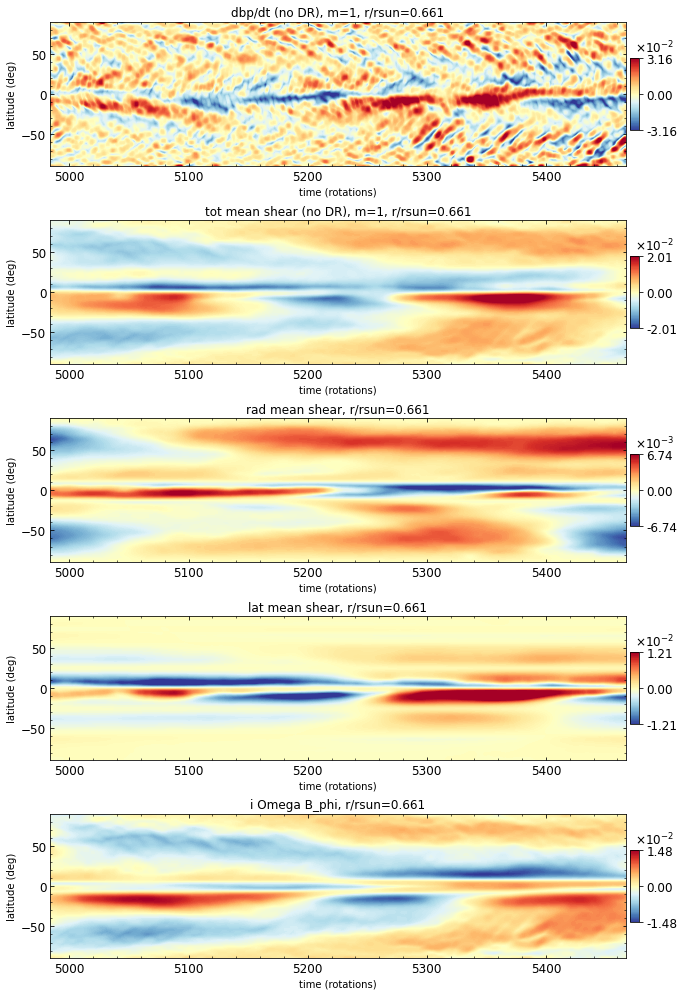

In [9]:
# now plot induction equation (remove advection by DR)

fig, axs, fpar = make_figure(nplots=5, ncol=1, sub_width_inches=8, sub_height_inches=2, margin_right_inches=3/4,\
                            margin_top_inches=1/4, margin_left_inches=5/8)

ax = axs[0, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('dbp/dt (no DR), m=1, r/rsun=%0.3f' %(radlevs.radius[irval]/rsun))
field = partfunc(dbpdt_nodr)
plot_timey(field, times/prot, tt_lat, fig, ax)

ax = axs[1, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('tot mean shear (no DR), m=1, r/rsun=%0.3f' %(radlevs.radius[irval]/rsun))
field = partfunc(ms_tot_nodr)
plot_timey(field, times/prot, tt_lat, fig, ax)

ax = axs[2, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('rad mean shear, r/rsun=%0.3f' %(radlevs.radius[irval]/rsun))
field = partfunc(ms_r)
plot_timey(field, times/prot, tt_lat, fig, ax)

ax = axs[3, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('lat mean shear, r/rsun=%0.3f' %(radlevs.radius[irval]/rsun))
field = partfunc(ms_t)
plot_timey(field, times/prot, tt_lat, fig, ax)

ax = axs[4, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('i Omega B_phi, r/rsun=%0.3f' %(radlevs.radius[irval]/rsun))
field = partfunc(1.0j*Omega_loc*bp)
plot_timey(field, times/prot, tt_lat, fig, ax)

savename = 'meanshear_nodr_' + part + '_mval%03i_rval%0.3f.png' %(mval, radlevs.radius[irval]/rsun) 
plt.savefig('meanshear_nodr/' + savename, dpi=300)

In [10]:
np.shape(bt)

(505, 384)

In [11]:
np.shape(thin_data(bt, 500))

(505, 384)